# 1 Time Series Forecasting with XGBoost<a id='1_Time_Series_Forecasting_with_XGBoost'></a>

## 1.1 Contents<a id='1.1_Contents'></a>
* [1 Time Series Forecasting with XGBoost](#1_Time_Series_Forecasting_with_XGBoost)
  * [1.1 Contents](#1.1_Contents)
  * [1.2 Overview](#1.2_Overview)
  * [1.3 Imports](#1.3_Imports)
  * [1.4 Functions](#1.4_Functions)
     * [1.4.1 Functions: series_to_supervised](#1.4.1_Functions:_series_to_superviesed)
     * [1.4.2 Functions: walk_forward_validation](#1.4.2_Functions:_walk_forward_validation)
     * [1.4.3 Functions: random_forest_forecast](#1.4.3_Functions:_random_forest_forecast)
     * [1.4.4 Functions: train_test_split](#1.4.4_Functions:_train_test_split)
     * [1.4.5 Functions: create_lagged_df](#1.4.5_Functions:_create_lagged_df)
  * [1.5 Load Data](#1.5_Load_Data)
  * [1.6 Organize Features and Targets with Lagging](#1.6_Organize_Features_and_Targets_with_Lagging) 
  * [1.7 Fit and Evaluate the Model](#1.7_Fit_and_Evaluate_the_Model)
  * [1.8 Visualize Model Performance](#1.8_Visualize_Model_Performance)
  * [1.9 Save the Model](#1.9_Save_the_Model)

## 1.2 Overview<a id='1.2_Overview'></a>

Add overview here!

## 1.3 Imports<a id='1.3_Imports'></a>

In [17]:
from collections import defaultdict
from pathlib import Path
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import graphviz
from pathlib import Path
from xgboost import XGBRegressor
from deepdiff import DeepDiff
from sklearn.metrics import mean_absolute_error
from sklearn.tree import export_graphviz
%matplotlib inline

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 5))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
)

## 1.4 Functions<a id='1.4_Functions'></a>

### 1.4.1 Functions: series_to_supervised<a id='1.4.1_Functions:_series_to_superviesed'></a>

In [18]:
# transform a time series dataset into a supervised learning dataset
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	#n_vars = 1 if type(data) is list else data.shape[1]
	df1 = pd.DataFrame(data)
	cols = list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df1.shift(i))
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df1.shift(-i))
	# put it all together
	agg = pd.concat(cols, axis=1)
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg.values

### 1.4.2 Functions: walk_forward_validation<a id='1.4.2_Functions:_walk_forward_validation'></a>

In [100]:
def walk_forward_validation(data, n_test, n_out=1):
    predictions = list()
	# split dataset
    train, test = train_test_split(data, n_test) # np arrays
	# seed history with training dataset
    history = [x for x in train] # array to list (why list? Easier to append?)
	# step over each time-step in the test set
    for i in range(len(test)):
		# split test row into input and output columns
        testX, testy = test[i, :-n_out], test[i, -n_out:]
		# fit model on history and make a prediction
        yhat, modelXG = xgboost_forecast(history, testX, n_out)
		# store forecast in list of predictions
        predictions.append(yhat)
		# add actual observation to history for the next loop
        history.append(test[i])
		# summarize progress
        print('>expected=%.1f, predicted=%.1f' % (np.mean(testy), np.mean(yhat)))	
    # estimate prediction error
    error = mean_absolute_error(test[:, -n_out:], predictions)
    return error, test[:, -n_out:], predictions, modelXG

### 1.4.3 Functions: XGBoost<a id='1.4.3_Functions:_XGBoost'></a>

In [118]:
# fit an xgboost model and make a one step prediction
def xgboost_forecast(train, testX, n_out=1):
	# transform list into array
	train = np.asarray(train)
	# split into input and output columns
	trainX, trainy = train[:, :-n_out], train[:, -n_out:]
	# fit model
	model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
	model.fit(trainX, trainy)
	# make a one-step prediction
	yhat = model.predict(np.asarray([testX]))
	return yhat[0], model

### 1.4.4 Functions: train_test_split<a id='1.4.4_Functions:_train_test_split'></a>

In [75]:
def train_test_split(data, n_test):
    return data[:-n_test,:], data[-n_test:,:]

### 1.4.5 Functions: create_lagged_df<a id='1.4.5_Functions:_create_lagged_df'></a>

In [76]:
def create_lagged_df(dataframeToLag, n_in=1, n_out=1, dropnan=False):
    dataframeToLag = pd.DataFrame(dataframeToLag)
    df_lagged = pd.DataFrame()
    df_lagged['date'] = dataframeToLag.index
    for col in dataframeToLag.columns:
        lag_arr = series_to_supervised(dataframeToLag[col], n_in, n_out, dropnan=False)
        lag_columns = [(col+'_'+str(lag)) for lag in range(n_in,-n_out,-1)]
        for lag in range(0,n_in+n_out):
            df_lagged[lag_columns[lag]]=lag_arr[:,lag]
    df_lagged.set_index('date', inplace=True)
    return df_lagged

## 1.5 Load Data<a id='1.5_Load_Data'></a>

In [77]:
# load the saved dictionary from pickle file
filePath_pickle = Path('/Users/parkj/Documents/pyDat/dataSet/covid_countryData.pickle')
pickle_in = open(filePath_pickle, 'rb')
country_dict = pickle.load(pickle_in)
df = country_dict['United States']

## 1.6 Organize Features and Targets with Lagging<a id='1.6_Organize_Features_and_Targets_with_Lagging'></a>

In [78]:
# time series features 
features_lag = ['rtrc', 'grph', 'prks', 'tran', 'work', 'resi', 'vac', 'dayow']
# create a dataframe with lagged features (mobility and vaccination data) 
df_feat_lag = create_lagged_df(df.loc[:,features_lag], n_in=7, n_out=0, dropnan=False)
# create a dataframe with lagged target (case)
df_targ_lag = create_lagged_df(df.case_mil_percMax, n_in=7, n_out=2, dropnan=False)
# join the feature and target data frames 
df_feat_targ = df_feat_lag.join(df_targ_lag, on='date', how='left')
# drop NaNs
df_feat_targ.dropna(inplace=True)

## 1.7 Fit and Evaluate the Model<a id='1.7_Fit_and_Evaluate_the_Model'></a>

>expected=22.1, predicted=22.2
>expected=19.4, predicted=20.6
>expected=13.7, predicted=16.9
>expected=14.9, predicted=16.7
>expected=19.2, predicted=16.5
>expected=19.3, predicted=20.8
>expected=20.8, predicted=20.4
>expected=20.5, predicted=22.3
>expected=17.6, predicted=16.6
>expected=12.7, predicted=14.4
>expected=18.8, predicted=16.8
>expected=18.0, predicted=15.4
>expected=19.7, predicted=17.8
>expected=20.1, predicted=20.2
>expected=20.5, predicted=20.1
>expected=18.5, predicted=17.4
>expected=11.3, predicted=13.1
>expected=17.1, predicted=11.7
>expected=17.9, predicted=14.4
>expected=28.9, predicted=20.4
>expected=22.5, predicted=29.8
>expected=25.8, predicted=23.6
>expected=20.9, predicted=20.6
>expected=14.4, predicted=16.0
>expected=23.1, predicted=16.4
>expected=20.4, predicted=22.9
>expected=22.2, predicted=26.3
>expected=26.3, predicted=23.2
>expected=23.3, predicted=26.7
>expected=21.1, predicted=21.4
>expected=11.7, predicted=17.9
>expected=25.8, predicted=15.6
>expecte

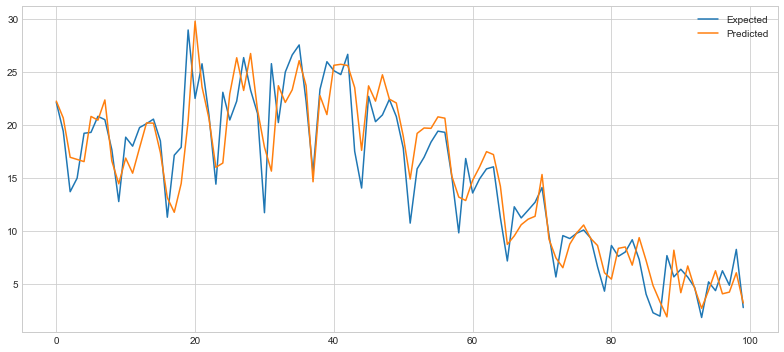

In [120]:
# evaluate
n_test = 100
n_out = 1
error, y, yhat, modelXG = walk_forward_validation(df_feat_targ.values, n_test, n_out) # n_test = 100
# plot expected vs predicted
plt.plot(y, label='Expected')
plt.plot(yhat, label='Predicted')
plt.legend()
plt.show()
#modelRF.feature_importances_[:-7]
df_xg_rez = pd.DataFrame({'date':df_feat_targ.index[-n_test:], 'y': [float(i) for i in y], 'yhat': yhat})
df_xg_rez.set_index('date',inplace=True)

## 1.8 Visualize Model Performance<a id='1.8_Visualize_Model_Performance'></a>

In [ ]:
# feature names used to fit the model 
feat_name = df_feat_targ.columns[:-n_out]
# sort features based on feature importances
sorted_idx = modelXG.feature_importances_.argsort()
# plot feature importance
plt.barh(feat_name[sorted_idx], modelXG.feature_importances_[sorted_idx])
plt.xlabel("Xgboost Feature Importance")
plt.show()

## 1.9 Save the Model<a id='1.9_Save_the_Model'></a>

In [172]:
# save the model
filePath_pickle = Path('/Users/parkj/Documents/pyDat/pyDatCode/covid19/covid19_case_timeSeries_modelRF.pkl')
pickle_out = open(filePath_pickle, 'wb') # open to write binary
pickle.dump(modelRF, pickle_out)
pickle_out.close()

In [13]:
# load the model
filePath_pickle = Path('/Users/parkj/Documents/pyDat/pyDatCode/covid19/covid19_case_timeSeries_modelRF.pkl')
pickle_in = open(filePath_pickle, 'rb') # open to read binary
modelRF = pickle.load(pickle_in)
pickle_in.close()

In [15]:
# visualize a decision tree of the random forest using 'export_graphviz' and 'graphviz'
tree_data = export_graphviz(modelRF.estimators_[0], 
                           feature_names=list(df_feat_targ.columns[:-2]),
                           filled=True, impurity=True, 
                           rounded=True)
graph = graphviz.Source(tree_data, format='pdf')
# render and save the figure 
graph.render('/Users/parkj/Documents/pyDat/pyDatCode/covid19/modelRF_exampleTree', view=True) 

NameError: name 'df_feat_targ' is not defined

RandomForestRegressor(n_estimators=1000)